[*********************100%***********************]  99 of 99 completed
[*********************100%***********************]  1 of 1 completed


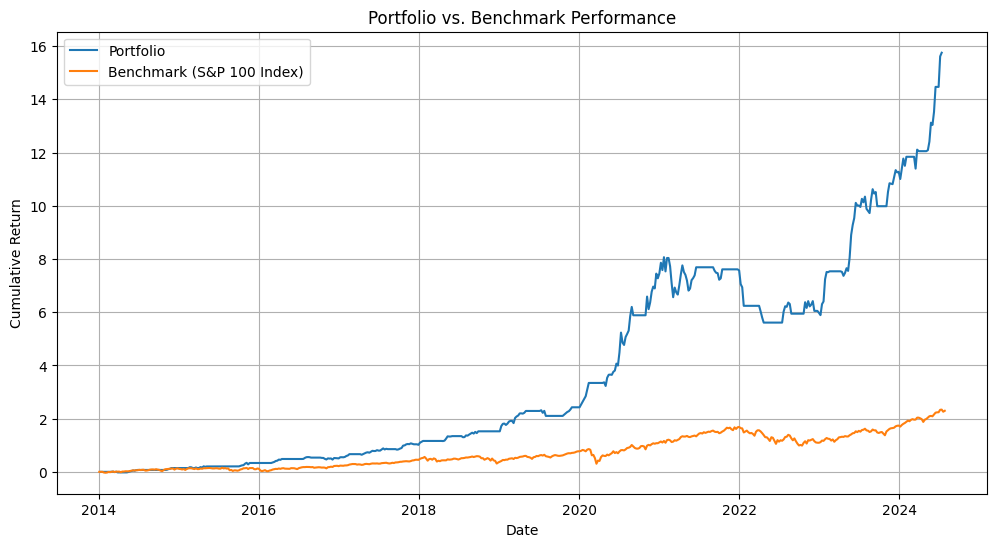

Final Portfolio Value: $1675187.48
CAGR: 30.72%
Max Drawdown: -27.11%

Monthly Returns (%):
Date
2015-01-31    14.26
2016-01-31    16.69
2017-01-31    16.99
2018-01-31    38.58
2019-01-31    30.25
2020-01-31    36.53
2021-01-31   122.02
2022-01-31   -15.16
2023-01-31    13.79
2024-01-31    51.75
2025-01-31    34.00
Freq: 12M

Current Top 5 Stocks by Sharpe Ratio:
NVDA: Sharpe Ratio = 0.86
TSLA: Sharpe Ratio = 0.58
LLY: Sharpe Ratio = 0.27
AVGO: Sharpe Ratio = 0.08
GE: Sharpe Ratio = -0.14


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define S&P 100 stock symbols
symbols = [
    "AAPL", "ABBV", "ABT", "ACN", "ADBE", "AIG", "AMGN", "AMT", "AMZN", "AVGO",
    "AXP", "BA", "BAC", "BK", "BKNG", "BLK", "BMY", "BRK-B", "C", "CAT",
    "CHTR", "CL", "CMCSA", "COF", "COP", "COST", "CRM", "CSCO", "CVS", "CVX",
    "DHR", "DIS", "DOW", "DUK", "EMR", "EXC", "F", "META", "FDX", "GD",
    "GE", "GILD", "GM", "GOOGL", "GS", "HD", "HON", "IBM", "INTC", "JNJ",
    "JPM", "KHC", "KO", "LIN", "LLY", "LMT", "LOW", "MA", "MCD", "MDLZ",
    "MDT", "MET", "META", "MMM", "MO", "MRK", "MS", "MSFT", "NEE", "NFLX",
    "NKE", "NVDA", "ORCL", "PEP", "PFE", "PG", "PM", "PYPL", "QCOM", "RTX",
    "SBUX", "SCHW", "SO", "SPG", "T", "TGT", "TMO", "TMUS", "TSLA", "TXN",
    "UNH", "UNP", "UPS", "USB", "V", "VZ", "WBA", "WFC", "WMT", "XOM"
]

benchmark_symbol = "^OEX"
start_date = "2001-01-01"
initial_balance = 100000
rolling_window = 252
risk_free_rate = 0.4  # Assuming 1% annual risk-free rate

# Fetch Historical Stock Data
historical_data = yf.download(symbols, start=start_date)['Adj Close']
benchmark_data = yf.download(benchmark_symbol, start=start_date)['Adj Close']

# Resample data to weekly on Fridays
historical_data = historical_data.resample('W-FRI').last()
benchmark_data = benchmark_data.resample('W-FRI').last()

# Calculate Weekly Returns
weekly_returns = historical_data.pct_change()

# Calculate Rolling Mean Returns, Standard Deviation, and Sharpe Ratio
rolling_mean_returns = weekly_returns.rolling(window=rolling_window).mean()
rolling_std_deviation = weekly_returns.rolling(window=rolling_window).std()

# Sharpe Ratio Calculation
annualized_mean_returns = rolling_mean_returns * 52  # Annualize the mean returns
annualized_std_deviation = rolling_std_deviation * np.sqrt(52)  # Annualize the standard deviation
sharpe_ratios = (annualized_mean_returns - risk_free_rate) / annualized_std_deviation

# Initialize Portfolio Variables
portfolio = {}
cash_balance = initial_balance
portfolio_values = []
purchase_prices = {}
portfolio_peak = initial_balance

# Read and process the NFCI data
nfci_data = pd.read_csv('nfci.csv')
nfci_data['date'] = pd.to_datetime(nfci_data['DATE'])
nfci_data.set_index('date', inplace=True)
# Resample to weekly on Fridays
nfci_data = nfci_data.resample('W-FRI').last()
nfci_data['nfci_sma_14'] = nfci_data['NFCI'].rolling(window=2).mean() 


# Combine NFCI data with historical data
combined_data = historical_data.join(nfci_data['NFCI'], how='inner')
combined_data['nfci_sma_14'] = nfci_data['nfci_sma_14']
combined_data['nfci_signal'] = np.where(combined_data['NFCI'] < combined_data['nfci_sma_14'], 1, 0)
combined_data['nfci_signal'] = combined_data['nfci_signal'].shift(1)

# Ensure that the weekly_returns index is aligned with combined_data index
weekly_returns = weekly_returns.reindex(combined_data.index)

# Rebalance Portfolio Function
def rebalance_portfolio(date, top_stocks, portfolio, cash_balance, prices):
    global purchase_prices
    new_portfolio = {}
    new_cash_balance = cash_balance

    for symbol, shares in portfolio.items():
        if symbol in prices:
            price = prices[symbol]
            new_cash_balance += price * shares

    num_stocks = len(top_stocks)
    if num_stocks > 0:
        position_size = new_cash_balance / num_stocks
        for symbol in top_stocks:
            if symbol in prices:
                stock_price = prices[symbol]
                shares_to_buy = position_size // stock_price
                new_portfolio[symbol] = shares_to_buy
                new_cash_balance -= shares_to_buy * stock_price
                purchase_prices[symbol] = stock_price

    return new_cash_balance, new_portfolio

# Calculate Portfolio Value Function
def calculate_portfolio_value(portfolio, cash_balance, prices):
    total_value = cash_balance
    for symbol, shares in portfolio.items():
        if symbol in prices:
            total_value += prices[symbol] * shares
    return total_value

# Backtest the Strategy
for date, row in weekly_returns.iterrows():
    if date >= pd.to_datetime(start_date):
        # Check the NFCI signal
        nfci_signal = combined_data.loc[date, 'nfci_signal']
        
        if nfci_signal == 0:
            # Risk-off: Move to cash
             cash_balance = calculate_portfolio_value(portfolio, cash_balance, historical_data.loc[date])
             portfolio={}
        else:
            # Risk-on: Rebalance portfolio
            cash_balance = calculate_portfolio_value(portfolio, cash_balance, historical_data.loc[date])
            portfolio = {}
            top_stocks = row[sharpe_ratios.loc[date].nlargest(5).index].dropna().index.tolist()
            prices = historical_data.loc[date]
            cash_balance, portfolio = rebalance_portfolio(date, top_stocks, portfolio, cash_balance, prices)
        
        # Calculate portfolio value
        portfolio_value = calculate_portfolio_value(portfolio, cash_balance, historical_data.loc[date])
        portfolio_values.append({'Date': date, 'Portfolio_Value': portfolio_value})

portfolio_performance = pd.DataFrame(portfolio_values).set_index('Date')
portfolio_performance['Portfolio_Return'] = portfolio_performance['Portfolio_Value'].pct_change()
portfolio_performance['Cumulative_Return'] = (1 + portfolio_performance['Portfolio_Return']).cumprod() - 1

# Calculate Yearly Returns
monthly_performance = portfolio_performance['Portfolio_Value'].resample('12M').last()
monthly_returns = monthly_performance.pct_change().dropna() * 100  # Convert to percentage

# Calculate CAGR
ending_value = portfolio_performance['Portfolio_Value'].iloc[-1]
beginning_value = initial_balance
num_years = (portfolio_performance.index[-1] - portfolio_performance.index[0]).days / 365.25
cagr = (ending_value / beginning_value) ** (1 / num_years) - 1

# Calculate Maximum Drawdown
rolling_max = portfolio_performance['Portfolio_Value'].cummax()
drawdown = (portfolio_performance['Portfolio_Value'] - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(portfolio_performance.index, portfolio_performance['Cumulative_Return'], label='Portfolio')
plt.plot(benchmark_data.index, (benchmark_data / benchmark_data.iloc[0]) - 1, label='Benchmark (S&P 100 Index)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio vs. Benchmark Performance')
plt.legend()
plt.grid(True)
plt.show()

# Print Final Portfolio Value, CAGR, Max Drawdown, and Monthly Performance
print(f"Final Portfolio Value: ${portfolio_performance['Portfolio_Value'].iloc[-1]:.2f}")
print(f"CAGR: {cagr:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")

print("\nMonthly Returns (%):")
print(monthly_returns.to_string(index=True, float_format="%.2f"))

# Print the current top 5 stocks ranked by Sharpe ratio
current_sharpe_ratios = sharpe_ratios.iloc[-1].dropna()
top_5_stocks = current_sharpe_ratios.nlargest(5).index.tolist()
print("\nCurrent Top 5 Stocks by Sharpe Ratio:")
for stock in top_5_stocks:
    print(f"{stock}: Sharpe Ratio = {current_sharpe_ratios[stock]:.2f}")
